In [1]:
import numpy as np
import torch
import pickle

In [2]:
import deepinv

/users/eleves-b/2021/jeremie.touati/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:numexpr.utils:Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:datasets:PyTorch version 2.5.1 available.


## Functions

In [3]:
def im2col_indices(kernel_shape, image_shape):
    a, b = kernel_shape
    H, W = image_shape
    out_h = H - a + 1
    out_w = W - b + 1

    rows = []
    for i in range(out_h):
        for j in range(out_w):
            patch_indices = []
            for di in range(a):
                for dj in range(b):
                    row_idx = i + di
                    col_idx = j + dj
                    patch_indices.append(row_idx * W + col_idx)
            rows.append(patch_indices)
    return np.array(rows)

def conv2d_to_matrix(phi, image_shape):
    H, W = image_shape
    a, b = phi.shape

    # Get im2col indices
    idx_matrix = im2col_indices((a, b), (H, W))
    
    # Each row of the Toeplitz matrix corresponds to one patch
    num_patches = idx_matrix.shape[0]
    
    K = np.zeros((num_patches, H * W))
    for i in range(num_patches):
        K[i, idx_matrix[i]] = phi.flatten()
    
    return K

In [4]:
import numpy as np

def conv2d_matrix_l1_norms(phi, image_shape):
    H, W = image_shape
    a, b = phi.shape
    out_h = H - a + 1
    out_w = W - b + 1
    
    l1_norms = np.zeros(H * W)

    for i in range(out_h):
        for j in range(out_w):
            for di in range(a):
                for dj in range(b):
                    row_idx = i + di
                    col_idx = j + dj
                    image_idx = row_idx * W + col_idx
                    l1_norms[image_idx] += abs(phi[di, dj])
    
    return l1_norms


In [5]:
conv2d_matrix_l1_norms(phi[0,0], (H, W))

NameError: name 'phi' is not defined

In [67]:
n_jobs=-1

def compute_l1_norms_for_k(k, c):
    return conv2d_matrix_l1_norms(phi[k, c], (H, W))

for c in range(C):
    # Parallel computation of l1_norms over kernels
    l1_norms_list = Parallel(n_jobs=n_jobs)(
        delayed(compute_l1_norms_for_k)(k, c) for k in tqdm(range(K), desc=f"Channel {c}")
    )
    l1_norms = np.sum(l1_norms_list, axis=0)
    print(l1_norms)

Channel 0: 100%|██████████| 3/3 [00:00<00:00, 2417.93it/s]


[ 16.  37.  48.  48.  48.  32.  11.  36.  68.  98.  98.  98.  62.  30.
  46.  92. 141. 141. 141.  95.  49.  46.  92. 141. 141. 141.  95.  49.
  46.  92. 141. 141. 141.  95.  49.  30.  55.  93.  93.  93.  63.  38.
  10.  24.  43.  43.  43.  33.  19.]


Channel 1: 100%|██████████| 3/3 [00:00<00:00, 8911.41it/s]


[ 12.  27.  44.  44.  44.  32.  17.  19.  52.  79.  79.  79.  60.  27.
  35.  83. 126. 126. 126.  91.  43.  35.  83. 126. 126. 126.  91.  43.
  35.  83. 126. 126. 126.  91.  43.  23.  56.  82.  82.  82.  59.  26.
  16.  31.  47.  47.  47.  31.  16.]


In [60]:
K = 3
C = 2
H = 7
W = 7
phi = torch.randint(0, 10, (K, C, 3, 3))
x = torch.randint(0, 10, (C, H, W))

Phi = conv2d_to_matrix(phi[0,0], x[0].shape)
A, B = Phi.shape
big_Phi = np.zeros((K*A, C*B))
for k in range(K):
    for c in range(C):
        big_Phi[k*A:(k+1)*A, c*B:(c+1)*B] = conv2d_to_matrix(phi[k,c], x[c].shape)

In [8]:
print(torch.nn.functional.conv2d(x.unsqueeze(0).float(), phi.float()))

tensor([[[[225., 346., 368., 252., 244.],
          [381., 298., 306., 194., 260.],
          [244., 239., 319., 212., 365.],
          [243., 235., 326., 225., 309.],
          [245., 171., 196., 208., 279.]],

         [[396., 496., 341., 440., 275.],
          [446., 458., 434., 382., 299.],
          [419., 372., 451., 479., 425.],
          [411., 429., 400., 368., 419.],
          [286., 335., 314., 374., 406.]],

         [[313., 429., 419., 347., 258.],
          [521., 507., 403., 344., 314.],
          [403., 434., 425., 372., 423.],
          [399., 407., 439., 434., 371.],
          [349., 286., 314., 321., 420.]]]])


In [9]:
big_Phi @ x.numpy().flatten()

array([225., 346., 368., 252., 244., 381., 298., 306., 194., 260., 244.,
       239., 319., 212., 365., 243., 235., 326., 225., 309., 245., 171.,
       196., 208., 279., 396., 496., 341., 440., 275., 446., 458., 434.,
       382., 299., 419., 372., 451., 479., 425., 411., 429., 400., 368.,
       419., 286., 335., 314., 374., 406., 313., 429., 419., 347., 258.,
       521., 507., 403., 344., 314., 403., 434., 425., 372., 423., 399.,
       407., 439., 434., 371., 349., 286., 314., 321., 420.])

In [ ]:
x = torch.randint(0, 3, (2, 5), dtype=torch.int32)
x

tensor([[2, 0, 0, 2, 0],
        [0, 2, 2, 1, 2]], dtype=torch.int32)

In [3]:
# Initialize param of size 3x2x3x with ints between 0 and 3
param = torch.randint(0, 3, (3, 2, 3), dtype=torch.int32)
param

tensor([[[1, 0, 1],
         [2, 2, 1]],

        [[0, 2, 2],
         [0, 0, 2]],

        [[0, 1, 1],
         [2, 1, 0]]], dtype=torch.int32)

In [89]:
Param = np.zeros((9,10), dtype=np.int32)
for k in range(3):
    for c in range(2):
        for i in range(3):
            for j in range(3):
                Param[k*3+i, c*5+i+j] = param[k, c, j]

In [90]:
Param

array([[1, 0, 1, 0, 0, 2, 1, 1, 0, 0],
       [0, 1, 0, 1, 0, 0, 2, 1, 1, 0],
       [0, 0, 1, 0, 1, 0, 0, 2, 1, 1],
       [1, 1, 1, 0, 0, 0, 1, 1, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 1, 1, 0, 0, 0, 1, 1],
       [0, 0, 1, 0, 0, 0, 2, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 2, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 2, 0]], dtype=int32)

In [ ]:
x_flatten = x.flatten().numpy()
y_flatten = Param@x_flatten

In [ ]:
print(Param.T @ y_flatten)
print(torch.nn.functional.conv_transpose1d(y, param.float()))

array([ 7, 16, 32, 24, 19,  6, 21, 43, 34, 16], dtype=int32)

In [87]:
toeplitz_matrix = toeplitz(kernel)
toeplitz_matrix

array([[1, 0, 0, 0],
       [0, 2, 0, 0],
       [0, 1, 0, 0],
       [0, 0, 0, 0]], dtype=int32)

In [75]:
# Torch conv
y = torch.nn.functional.conv1d(x.unsqueeze(0).float(), param.float())
y

tensor([[[3., 5., 8.],
         [4., 7., 8.],
         [2., 4., 3.]]])

In [28]:
# import experiments_old/denoisers.pkl
import pickle
with open("experiments_old/denoisers.pkl", "rb") as f:
    denoisers = pickle.load(f)

/users/eleves-b/2021/jeremie.touati/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
INFO:numexpr.utils:Note: NumExpr detected 28 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:datasets:PyTorch version 2.5.1 available.


In [36]:
net = denoisers["AD_10C_1L_1R"]["net"]

In [ ]:
# Create image of size 3x200x200
image = torch.randint(0, 3, (3, 200, 200), dtype=torch.int32)
image = image.to(next(net.parameters()).device)
y = net.conv(image.unsqueeze(0).float(), net.parameter.float())

In [47]:
net.convt(y, net.parameter.float()).shape

torch.Size([1, 3, 200, 200])

## Tests

In [6]:
import time
import pickle

import scipy
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio

import torch
import torch.nn as nn

#import deepinv

from pnp_unrolling.unrolled_cdl import UnrolledCDL
from utils.measurement_tools import get_operators
from utils.tools import op_norm2
from pnp_unrolling.datasets import (
    create_imagenet_dataloader,
)


def plot_img(img, ax, title=None):
    img = img.detach().cpu().numpy().transpose(1, 2, 0).clip(0, 1)
    ax.imshow(img)
    ax.set_axis_off()
    if title:
        ax.set_title(title)


DATASET = "bsd"
COLOR = True
DEVICE = "cuda:0" #"cuda:3"
STD_NOISE = 0.05

# Here the dataset is "BSD" but we use the same create_imagenet_dataloader
# function which need to set dataset="imagenet"
create_dataloader = create_imagenet_dataloader
DATA_PATH = "./BSDS500/BSDS500/data/images"
DATASET = "imagenet"

In [7]:
# Loading DENOISERS
with open("experiments_old/denoisers.pkl", "rb") as f:
    DENOISERS = pickle.load(f)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def apply_model(model, x, dual, reg_par, net=None, update_dual=False):

    if model == "unrolled":
        net.set_lmbd(reg_par)
        x_torch = torch.tensor(x, device=DEVICE, dtype=torch.float)[None, :]
        if dual is not None:
            dual = torch.tensor(dual, device=DEVICE, dtype=torch.float)
        with torch.no_grad():
            xnet, new_dual = net(x_torch, dual)
        if not update_dual:
            return xnet.detach().cpu().numpy()[0], None
        else:
            return (
                xnet.detach().cpu().numpy()[0],
                new_dual.detach().cpu().numpy()
            )
    elif model == "identity":
        return x, None
    elif model == "drunet":
        x_torch = torch.tensor(x, device=DEVICE, dtype=torch.float)[None, :]
        with torch.no_grad():
            xnet = net(x_torch, reg_par)
        return np.clip(xnet.detach().cpu().numpy()[0], 0, 1), None


def Phi_channels(x, Phi):

    new_x = np.concatenate(
        [Phi(x[i])[None, :] for i in range(x.shape[0])],
        axis=0
    )

    return new_x

def lambda_max_synthesis(y, net, Phit):
    
    parameter = net.parameter
    Astar_y = Phi_channels(y, Phit)
    Astar_y = torch.tensor(Astar_y, device=DEVICE, dtype=torch.float)[None, :]
    Dstar_Astar_y = net.conv(Astar_y, parameter).detach().cpu().numpy()
    return np.max(np.abs(Dstar_Astar_y))

def error_analysis(x, y, net, Phi, lamb):
    
    error1 = (1/2) * np.sum((Phi_channels(x, Phi) - y) ** 2)
    x = torch.tensor(x, device=DEVICE, dtype=torch.float)[None, :]
    gamma_star_x = net.conv(x, net.parameter).detach().cpu().numpy()
    error2 = np.sum(np.abs(gamma_star_x))
    
    return error1 + lamb * error2

def error_synthesis(z, y, net, Phi, lamb):
    
    error2 = np.sum(np.abs(z))
    z = torch.tensor(z, device=DEVICE, dtype=torch.float)[None, :]
    D_z = net.convt(z, net.parameter).detach().cpu().numpy()
    A_D_z = Phi_channels(D_z, Phi)
    error1 = (1/2) * np.sum((A_D_z - y) ** 2)
    
    return error1 + lamb * error2

In [13]:
def pnp_deblurring(
    model,
    pth_kernel,
    x_observed,
    normPhi2=None,
    n_iter_per_lambda=10,
    lambda_list=None,
    warm_restart=True,
    eps_stop=None,
    net=None,
    update_dual=False,
    x_truth=None,
):

    n_lambda = len(lambda_list)
    if lambda_list is None:
        lambda_list = [0.5 * STD_NOISE] * n_lambda

    model_type = model
    if model in ["analysis", "synthesis"]:
        model = "unrolled"

    Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
    if normPhi2 is None:
        normPhi2 = op_norm2(Phi, Phit, x_observed.shape)
    gamma = 1.0 / normPhi2

    x_n = Phi_channels(x_observed, Phit)
    best_x = x_n.copy()
    best_psnr = 0
    best_lambda = 0
    
    cvg = [1e10] * n_lambda*n_iter_per_lambda
    psnr = [0] * n_lambda
    error = [0] * n_lambda
    psnr_inner = [0] * n_lambda*n_iter_per_lambda
    error_inner = [0] * n_lambda*n_iter_per_lambda
    runtime = [0] * n_lambda*n_iter_per_lambda
    stops = [0] * (n_lambda+1)
    
    current_dual = None
    t_iter = 0
    
    i = 0
    for k in tqdm(range(n_lambda)):
        print(f"lambda: {lambda_list[k]}")
        
        if not warm_restart:
            x_n = Phi_channels(x_observed, Phit)
            current_dual = None
        
        for _ in range(n_iter_per_lambda):
            t_start = time.perf_counter()
            g_n = Phi_channels((Phi_channels(x_n, Phi) - x_observed), Phit)
            tmp = x_n - gamma * g_n
            x_old = x_n.copy()
            x_n, current_dual = apply_model(
                model, tmp, current_dual, lambda_list[k], net, update_dual
            )
            t_iter += time.perf_counter() - t_start
            cvg[i] = np.sum((x_n - x_old) ** 2)
            runtime[i] = t_iter
            psnr_inner[i] = peak_signal_noise_ratio(x_n, x_truth)
            criterion = np.sum((x_n - x_old) ** 2 / np.sum(x_old ** 2))
            
            if model_type == "analysis":
                error_inner[i] = error_analysis(x_n, x_observed, net, Phi, lambda_list[k])
            elif model_type == "synthesis":
                error_inner[i] = error_synthesis(current_dual[0], x_observed, net, Phi, lambda_list[k])
                
            if eps_stop is not None and criterion < eps_stop:
                break
            i += 1
        
            # Show x_n
        plt.imshow(x_n.transpose(1, 2, 0))
        plt.show()
        print(x_n[:,10:-10, 10:-10].sum())
        
        stops[k+1] = i
        
        if x_truth is not None:
            psnr[k] = psnr_inner[i-1]
            error[k] = error_inner[i-1]
            if psnr[k] > best_psnr:
                best_psnr = psnr[k]
                best_x = x_n.copy()
                best_lambda = lambda_list[k]
            

    return dict(img=np.clip(x_n, 0, 1),
                cvg=cvg,
                psnr=psnr,
                error=error,
                time=runtime,
                lambda_list=lambda_list,
                psnr_inner=psnr_inner,
                error_inner=error_inner,
                stops=stops,
                best_img=np.clip(best_x, 0, 1),
                best_psnr=best_psnr,
                best_lambda=best_lambda)




def generate_results_pnp(pth_kernel,
                         img,
                         n_iter_per_lambda=10,
                         n_lambda=100,
                         lambda_start=10,
                         lambda_end=1e-5,
                         eps_stop=None,
                         warm_restart=True
):

    h = scipy.io.loadmat(pth_kernel)
    h = np.array(h["blur"])

    Phi, Phit = get_operators(type_op="deconvolution", pth_kernel=pth_kernel)
    x_blurred = Phi_channels(img, Phi)
    nc, nxb, nyb = x_blurred.shape
    x_observed = x_blurred + STD_NOISE * np.random.randn(nc, nxb, nyb)
    normPhi2 = op_norm2(Phi, Phit, x_observed.shape)
    lambdas = np.logspace(np.log10(lambda_start), np.log10(lambda_end), n_lambda)

    results = {
        "observation": x_observed,
        "truth": img
    }    
    
    for name, denoiser in DENOISERS.items():
        if name in sublist_denoisers:
            
            if denoiser["model"] == "synthesis":
                lambda_max = lambda_max_synthesis(x_observed, denoiser["net"], Phit)
                lambda_list = np.logspace(np.log10(1*lambda_max), np.log10(1e-5 * lambda_max), n_lambda)
            elif denoiser["model"] == "drunet":
                lambda_list = np.logspace(np.log10(1e3), np.log10(1e-2), n_lambda)
            else:
                lambda_max = lambda_max_analysis(x_observed, denoiser["net"], Phit)
                lambda_list = np.logspace(np.log10(1*lambda_max), np.log10(1e-5 * lambda_max), n_lambda)
                # lambda_max = lambda_max_analysis(x_observed, denoiser["net"], Phit)
                # lambda_list = np.logspace(np.log10(0.5*lambda_max), np.log10(1e-5 * lambda_max), n_lambda)
            
            results[name] = pnp_deblurring(
                denoiser["model"],
                pth_kernel,
                x_observed,
                normPhi2=normPhi2,
                n_iter_per_lambda=n_iter_per_lambda,
                lambda_list=lambda_list,
                eps_stop=eps_stop,
                warm_restart=warm_restart,
                update_dual=True,
                net=denoiser["net"],
                x_truth=img,
            )

    return results

### Draft

In [22]:
import numpy as np
from scipy.sparse import coo_matrix
from joblib import Parallel, delayed
from tqdm import tqdm

def im2col_indices(kernel_shape, image_shape):
    a, b = kernel_shape
    H, W = image_shape
    out_h = H - a + 1
    out_w = W - b + 1

    rows = []
    for i in range(out_h):
        for j in range(out_w):
            patch_indices = []
            for di in range(a):
                for dj in range(b):
                    row_idx = i + di
                    col_idx = j + dj
                    patch_indices.append(row_idx * W + col_idx)
            rows.append(patch_indices)
    return np.array(rows)

def sparse_conv_entries(phi, image_shape, row_offset=0, col_offset=0):
    H, W = image_shape
    a, b = phi.shape
    out_h = H - a + 1
    out_w = W - b + 1

    idx_matrix = im2col_indices((a, b), (H, W))
    kernel_flat = phi.flatten()

    data = []
    row_indices = []
    col_indices = []

    for i, patch_indices in enumerate(idx_matrix):
        for j, col in enumerate(patch_indices):
            row_indices.append(row_offset + i)
            col_indices.append(col_offset + col)
            data.append(kernel_flat[j])

    return row_indices, col_indices, data

def build_big_Phi_sparse_c(parameter, N1, N2, c, n_jobs=-1):
    """
    Compute the c-th vertical block of big_Phi_sparse using parallelism over k.

    Args:
        parameter: shape (K, C, a, b)
        N1, N2: image shape
        c: input channel index (0 <= c < C)
        n_jobs: number of parallel workers

    Returns:
        Sparse matrix of shape (K*A, B) corresponding to column block c
    """
    K, C, a, b = parameter.shape
    H, W = N1, N2

    A = (H - a + 1) * (W - b + 1)
    B = H * W
    total_rows = K * A

    def process_k(k):
        r_off = k * A
        phi_kc = parameter[k, c]
        return sparse_conv_entries(phi_kc, (H, W), row_offset=r_off, col_offset=0)

    results = Parallel(n_jobs=n_jobs)(
        delayed(process_k)(k) for k in tqdm(range(K), desc=f"Parallel over k for c={c}")
    )

    row_inds, col_inds, data_vals = zip(*results)
    row_inds = np.concatenate(row_inds)
    col_inds = np.concatenate(col_inds)
    data_vals = np.concatenate(data_vals)

    return coo_matrix((data_vals, (row_inds, col_inds)), shape=(total_rows, B)).tocsr()

In [ ]:
def lambda_max_analysis(y, net, Phit):
    
    parameter = net.parameter.detach().cpu().numpy()
    C, N1, N2 = y.shape
    K = parameter.shape[0]
    
    # A, B = conv2d_to_matrix(parameter[0,0], (N1, N2)).shape
    # big_Phi = np.zeros((K*A, C*B))
    # for k in range(K):
    #     for c in range(C):
    #         big_Phi[k*A:(k+1)*A, c*B:(c+1)*B] = conv2d_to_matrix(parameter[k,c], (N1, N2))
    
    # print(f"big_Phi shape: {big_Phi.shape}")
    # print(f"y shape: {y.shape}")
    # print(f"y flatten shape: {y.flatten().shape}")
    
    Astar_y = Phi_channels(y, Phit)
    lambda_max = 0
    for c in range(C):
        big_Phi_c = build_big_Phi_sparse_c(parameter, N1, N2, c)
        # Show size of big_Phi_c
        print(f"big_Phi_c size: {big_Phi_c.data.nbytes / 1024**2:.2f} MB")
        for n1 in tqdm(range(N1)):
            for n2 in range(N2):
                # Sum elements of big_Phi having column n1*N2 + n2
                norm_gamma_star_i = np.sum(np.abs(big_Phi_c[:, n1*N2 + n2].data))                
                current_lambda = np.abs(Astar_y[c, n1, n2] / norm_gamma_star_i)
                if current_lambda > lambda_max:
                    lambda_max = current_lambda
                    
    return lambda_max

### Clean

In [16]:
from joblib import Parallel, delayed

def lambda_max_analysis(y, net, Phit, n_jobs=-1):
    
    parameter = net.parameter.detach().cpu().numpy()
    C, N1, N2 = y.shape
    K = parameter.shape[0]
    
    Astar_y = Phi_channels(y, Phit)
    lambda_max = 0
    
    def compute_l1_norms_for_k(k, c):
        return conv2d_matrix_l1_norms(parameter[k, c], (N1, N2))

    for c in range(C):
        l1_norms_list = Parallel(n_jobs=n_jobs)(
            delayed(compute_l1_norms_for_k)(k, c) for k in range(K)
        )
        l1_norms = np.sum(l1_norms_list, axis=0)
        
        for n1 in range(N1):
            for n2 in range(N2):
                norm_gamma_star_i = l1_norms[n1*N2 + n2]
                current_lambda = np.abs(Astar_y[c, n1, n2] / norm_gamma_star_i)
                if current_lambda > lambda_max:
                    lambda_max = current_lambda
    
    print(f"lambda_max: {lambda_max}")
                    
    return lambda_max

Processing image 4...
lambda_max: 0.28263319970193895


  0%|          | 0/50 [00:00<?, ?it/s]

lambda: 0.28263319970193895


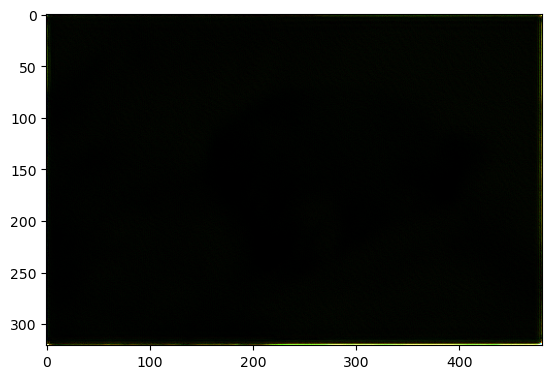

  2%|▏         | 1/50 [00:05<04:13,  5.18s/it]

2645.5547
lambda: 0.22345102896806343


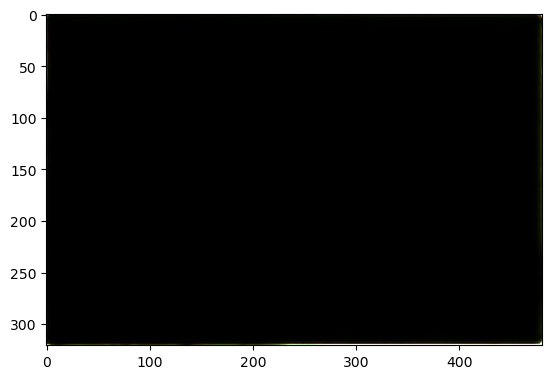

  4%|▍         | 2/50 [00:10<04:07,  5.15s/it]

187.78061
lambda: 0.17666134905432976


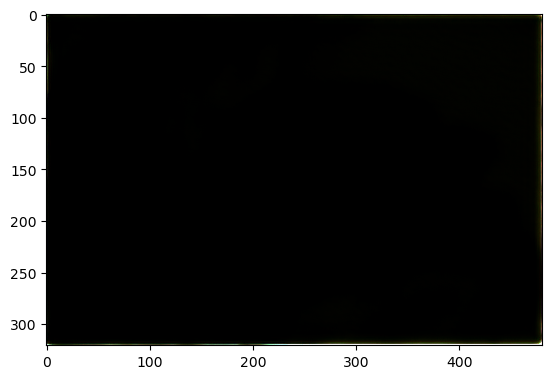

  6%|▌         | 3/50 [00:15<04:01,  5.15s/it]

522.1803
lambda: 0.13966922593207792


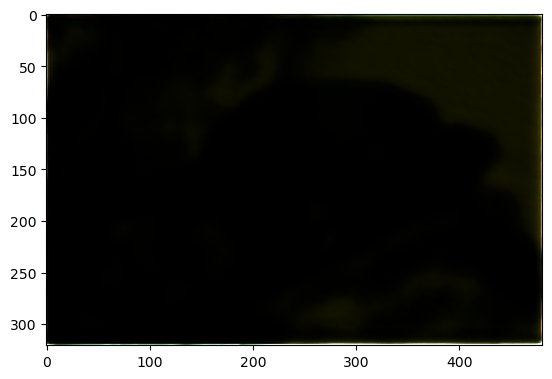

  8%|▊         | 4/50 [00:20<03:56,  5.14s/it]

3965.2869
lambda: 0.11042309354530383


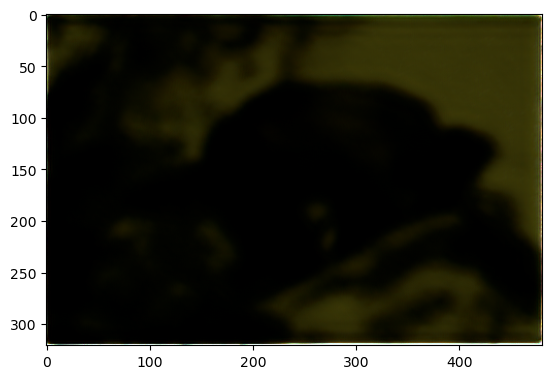

 10%|█         | 5/50 [00:25<03:51,  5.14s/it]

16337.036
lambda: 0.08730097490512753


 10%|█         | 5/50 [00:30<04:32,  6.05s/it]


KeyboardInterrupt: 

In [17]:
STD_NOISE = 0.1
pth_kernel = "blur_models/blur_1.mat"
#pth_kernel = "blur_models/blur_3.mat"

dataloader = create_dataloader(
    DATA_PATH,
    min_sigma_noise=STD_NOISE,
    max_sigma_noise=STD_NOISE,
    device=DEVICE,
    dtype=torch.float,
    mini_batch_size=1,
    train=False,
    color=COLOR,
    fixed_noise=True,
    crop=False,
)

base_names = [
    #"AD_10C_1L",
    #"AD_10C_20L",
    "AD_50C_1L",
    # "AD_50C_20L",
    # "AD_100C_1L",
    # "AD_100C_20L",
]
sublist_denoisers = [denoiser for denoiser in DENOISERS.keys() if any(base_name in denoiser for base_name in base_names)]

indices = [4]#0,1,2]
list_results = []
for i in indices:
    print(f"Processing image {i}...")
    img = dataloader.dataset[i][1].cpu().numpy()
    img_noise = dataloader.dataset[i][0].cpu().numpy()
    #big_Phi = build_big_Phi_sparse(DENOISERS["AD_10C_1L_1R"]["net"].parameter, img.shape[1], img.shape[2])
    results = generate_results_pnp(pth_kernel, img, n_iter_per_lambda=50, n_lambda=50, eps_stop=1e-5)
    list_results.append(results)